In [137]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from sklearn import preprocessing

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [138]:
train_limpio = pd.read_csv("train_limpio_con_BOW_de_5000_y_Stemming_noDrops.csv",encoding = "ISO-8859-1").sample(frac=1).reset_index(drop=True)
test_limpio = pd.read_csv("test_limpio_con_BOW_de_5000_y_Stemming_noDrops.csv",encoding = "ISO-8859-1").sample(frac=1).reset_index(drop=True)

In [139]:
train_limpio["text"] = train_limpio["text"].map(lambda x : "null" if(x is None) else x)
test_limpio["text"] = test_limpio["text"].map(lambda x : "null" if(x is None) else x)

In [140]:
train_limpio_true = train_limpio.loc[train_limpio["target"] == 1]
train_limpio_false = train_limpio.loc[train_limpio["target"] == 0]

In [141]:
print("Tenemos {cant_verdaderos: .2f} verdaderos y {cant_falsos: .2f} falsos".format(cant_verdaderos=len(train_limpio_true), cant_falsos=len(train_limpio_false)))

Tenemos  3271.00 verdaderos y  4342.00 falsos


## Voy a balancear el train y el validation, misma cantidad de falsos y verdaderos en ambos

In [142]:
train = pd.concat([train_limpio_true.iloc[:2616], train_limpio_false.iloc[:3473]])
val = pd.concat([train_limpio_true.iloc[2616:3000], train_limpio_false.iloc[3473:3850]])
test = pd.concat([train_limpio_true.iloc[3000:], train_limpio_false.iloc[3850:]])

In [143]:
train.head(2)

,aa,ab,aba,abandon,abbott,abbswinston,abc,abcnew,abe,abil,...,y\/e\/l-location,yorkshire\\n-location,youtube\.com\/channel\/UCHWTLC9B4ZjUGh7yDlb55Iw-location,zboyer\@washingtontimes\.com-location,longitud_tweet,letras_seguidas,sentimiento,objetividad,keyword,location
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,110,2,0.0,0.0,injur,Mumbai
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,60,2,0.0,0.0,bomb,NaN


In [144]:
vectorizer = CountVectorizer()
vectorizer.fit(train_limpio["text"].values.astype('U'))

X_train = vectorizer.transform(train["text"].values.astype('U'))
X_val  = vectorizer.transform(val["text"].values.astype('U'))
X_test = vectorizer.transform(test["text"].values.astype('U'))

actual_tp_test_only_text = vectorizer.transform(test_limpio["text"].values.astype('U'))

In [145]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Primer modelo simple

In [146]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 10)                133800    
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 11        
Total params: 133,811
Trainable params: 133,811
Non-trainable params: 0
_________________________________________________________________


In [147]:
first_history = model.fit(X_train, train["target"].to_numpy(),
                    epochs=100,
                    verbose=True,
                    validation_data=(X_val, val["target"].to_numpy()),
                    batch_size=10)

Epoch 1/100
609/609 [==============================] - 1s 1ms/step - loss: 0.5356 - acc: 0.7647 - val_loss: 0.4878 - val_acc: 0.7766
Epoch 2/100
609/609 [==============================] - 1s 1ms/step - loss: 0.3361 - acc: 0.8703 - val_loss: 0.4811 - val_acc: 0.7963
Epoch 3/100
609/609 [==============================] - 1s 1ms/step - loss: 0.2309 - acc: 0.9192 - val_loss: 0.5168 - val_acc: 0.7792
Epoch 4/100
609/609 [==============================] - 1s 1ms/step - loss: 0.1647 - acc: 0.9465 - val_loss: 0.5451 - val_acc: 0.7884
Epoch 5/100
609/609 [==============================] - 1s 1ms/step - loss: 0.1242 - acc: 0.9586 - val_loss: 0.5918 - val_acc: 0.7753
Epoch 6/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0986 - acc: 0.9658 - val_loss: 0.6414 - val_acc: 0.7687
Epoch 7/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0814 - acc: 0.9708 - val_loss: 0.6805 - val_acc: 0.7661
Epoch 8/100
609/609 [==============================] - 1s 1ms/step - 

609/609 [==============================] - 1s 1ms/step - loss: 0.0292 - acc: 0.9836 - val_loss: 1.8859 - val_acc: 0.7135
Epoch 63/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0303 - acc: 0.9841 - val_loss: 1.8613 - val_acc: 0.7122
Epoch 64/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0297 - acc: 0.9851 - val_loss: 1.8510 - val_acc: 0.7188
Epoch 65/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0294 - acc: 0.9844 - val_loss: 1.8703 - val_acc: 0.7162
Epoch 66/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0293 - acc: 0.9846 - val_loss: 1.8884 - val_acc: 0.7135
Epoch 67/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0294 - acc: 0.9836 - val_loss: 1.9042 - val_acc: 0.7109
Epoch 68/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0299 - acc: 0.9849 - val_loss: 1.8874 - val_acc: 0.7175
Epoch 69/100
609/609 [==============================] - 1s 2ms/step - loss:

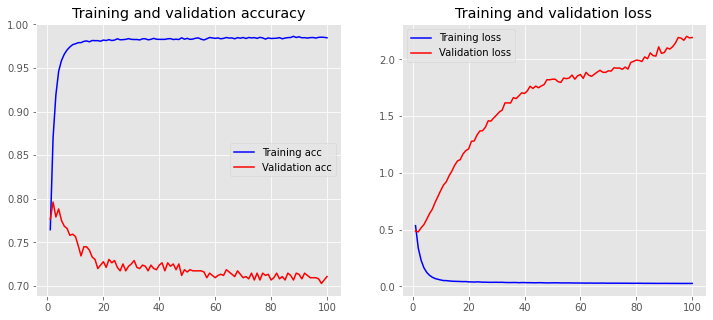

In [148]:
plot_history(first_history)

In [149]:
loss, accuracy = model.evaluate(X_test, test["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7195


In [150]:
firstPredictions = list(map(lambda x: x[0], model.predict_classes(actual_tp_test_only_text)))

In [151]:
firstPredictionsDF = pd.DataFrame(data={'id': test_limpio["id"], 'target': firstPredictions})
firstPredictionsDF.head(10)

,id,target
0,7667,0
1,9412,0
2,5026,0
3,8127,1
4,1404,0
5,2331,0
6,1370,0
7,10190,1
8,9399,1
9,5216,0


In [152]:
firstPredictionsDF.to_csv('NN_predictions_first_model.csv', index=False)

## Segundo modelo, agrego ciudades y Tokenizer en vez de count para las words

In [153]:
non_null_locations = train_limpio[train_limpio.location.notnull()]["location"].to_numpy()
non_null_locations

array(['Mumbai', 'Worldwide', 'Portugal', ..., 'Planet Earth',
       'eARth\\ 3', 'playing\\ soccer\\ \\&\\ eating\\ pizza'],
      dtype=object)

In [154]:
encoder = LabelEncoder()
locations = encoder.fit_transform(non_null_locations)
len(locations)

5080

In [155]:
encoder = OneHotEncoder(sparse=False)
locations = locations.reshape((5080, 1))
encoder.fit_transform(locations)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [156]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_limpio["text"].values.astype('U'))

X_train = tokenizer.texts_to_sequences(train["text"].values.astype('U'))
X_val = tokenizer.texts_to_sequences(val["text"].values.astype('U'))
X_test = tokenizer.texts_to_sequences(test["text"].values.astype('U'))

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(train_limpio["text"].values[2])
print(X_train[2])

japan mark anniversari of hiroshima atom bomb
[443, 56, 7, 105, 12, 748, 53, 215, 10, 215, 1080, 30, 48, 23, 12, 58, 4, 57, 53, 25, 191, 156, 749]


In [157]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## Pruebo solo texto, modelo mas complejo con maxPooling y mejor embedding

In [158]:
embedding_dim = 50

model1 = Sequential()
model1.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model1.add(layers.GlobalMaxPool1D())
model1.add(layers.Dense(10, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model1.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 50)           675500    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 50)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 11        
Total params: 676,021
Trainable params: 676,021
Non-trainable params: 0
_________________________________________________________________


Testing Accuracy:  0.7471


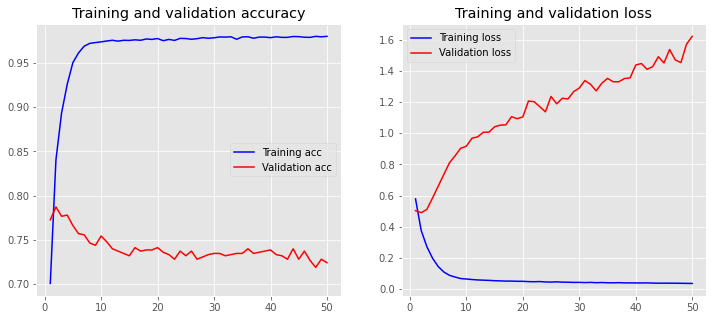

In [159]:
second_history = model1.fit(X_train, train["target"].to_numpy(),
                    epochs=50,
                    verbose=False,
                    validation_data=(X_val, val["target"].to_numpy()),
                    batch_size=10)

loss, accuracy = model1.evaluate(X_test, test["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(second_history)

## Tercer modelo

In [160]:
embedding_dim = 100

model2 = Sequential()
model2.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model2.add(layers.Conv1D(128, 5, activation='relu'))
model2.add(layers.GlobalMaxPooling1D())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model2.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 100)          1351000   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 11        
Total params: 1,416,429
Trainable params: 1,416,429
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
609/609 [==============================] - 8s 13ms/step - loss: 0.5121 - acc: 0.7461 - val_loss: 0.4924 - val_acc: 0.7845
Epoch 2/10
609/609 [==============================] - 8s 12ms/step - loss: 0.3174 - acc: 0.8696 - val_loss: 0.5071 - val_acc: 0.7635
Epoch 3/10
609/609 [==============================] - 8s 12ms/step - loss: 0.2005 - acc: 0.9254 - val_loss: 0.6691 - val_acc: 0.7714
Epoch 4/10
609/609 [==============================] - 8s 12ms/step - loss: 0.1245 - acc: 0.9593 - val_loss: 0.7542 - val_acc: 0.7569
Epoch 5/10
609/609 [==============================] - 8s 12ms/step - loss: 0.0897 - acc: 0.9698 - val_loss: 0.8774 - val_acc: 0.7569
Epoch 6/10
609/609 [==============================] - 8s 13ms/step - loss: 0.0697 - acc: 0.9752 - val_loss: 0.8818 - val_acc: 0.7503
Epoch 7/10
609/609 [==============================] - 8s 13ms/step - loss: 0.0559 - acc: 0.9780 - val_loss: 1.0825 - val_acc: 0.7543
Epoch 8/10
609/609 [==============================] - 8s 13ms/step - 

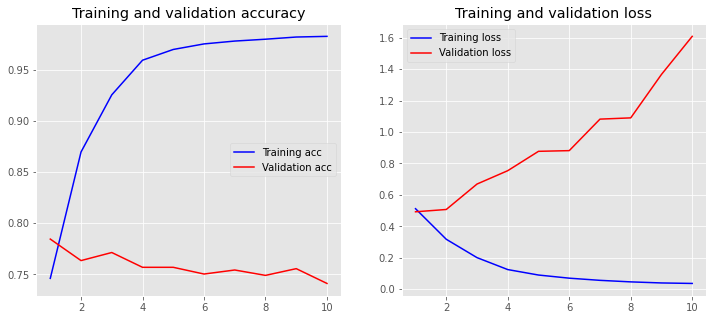

In [161]:
third_history = model2.fit(X_train, train["target"].to_numpy(),
                    epochs=10,
                    verbose=True,
                    validation_data=(X_val, val["target"].to_numpy()),
                    batch_size=10)
loss, accuracy = model2.evaluate(X_train, train["target"].to_numpy(), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test, test["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(third_history)


## Cuarto Modelo

In [162]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model3 = Sequential()
    model3.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model3.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model3.add(layers.GlobalMaxPooling1D())
    model3.add(layers.Dense(10, activation='relu'))
    model3.add(layers.Dense(1, activation='sigmoid'))
    model3.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model3

param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [163]:
# # Main settings
# epochs = 20
# embedding_dim = 50
# maxlen = 100
# output_file = 'output.txt'

# source = "twitter"
# # Run grid search for each source (yelp, amazon, imdb)
# print('Running grid search for data set :', "twitter")
# sentences = train_limpio["text"].values.astype('U')
# # Train-test split
# train = pd.concat([train_limpio_true.iloc[:3000], train_limpio_false.iloc[:4000]]).sample(frac=1).reset_index(drop=True)
# test = pd.concat([train_limpio_true.iloc[3000:], train_limpio_false.iloc[4000:]]).sample(frac=1).reset_index(drop=True)

# # Tokenize words
# tokenizer = Tokenizer(num_words=5000)
# tokenizer.fit_on_texts(sentences)
# X_train = tokenizer.texts_to_sequences(train["text"].values.astype('U'))
# X_test = tokenizer.texts_to_sequences(test["text"].values.astype('U'))

# # Adding 1 because of reserved 0 index
# vocab_size = len(tokenizer.word_index) + 1

# # Pad sequences with zeros
# X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# # Parameter grid for grid search
# param_grid = dict(num_filters=[32, 64, 128],
#                       kernel_size=[3, 5, 7],
#                       vocab_size=[vocab_size],
#                       embedding_dim=[embedding_dim],
#                       maxlen=[maxlen])
# model3 = KerasClassifier(build_fn=create_model,
#                         epochs=epochs, batch_size=10,
#                             verbose=False)
# grid = RandomizedSearchCV(estimator=model3, param_distributions=param_grid,
#                               cv=10, verbose=1, n_iter=10)
# grid_result = grid.fit(X_train, train["target"])

# # Evaluate testing set
# test_accuracy = grid.score(X_test, test["target"])

# # Save and evaluate results
# #     prompt = input(f'finished {source}; write to file and proceed? [y/n]')
# #     if prompt.lower() not in {'y', 'true', 'yes'}:
# #         break
# #     with open(output_file, 'w+') as f:
# s = ('Running {} data set\nBest Accuracy : '
#              '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
# output_string = s.format(
#         source,
#         grid_result.best_score_,
#         grid_result.best_params_,
#         test_accuracy)
# print(output_string)
# #         f.write(output_string)

# Modelo con tf idf

In [164]:
train_limpio_tf_idf = pd.read_csv("train_limpio_con_Tf-Idf.csv",encoding = "ISO-8859-1").sample(frac=1).reset_index(drop=True)
test_limpio_tf_idf = pd.read_csv("test_limpio_con_Tf-Idf.csv",encoding = "ISO-8859-1").sample(frac=1).reset_index(drop=True)

In [165]:
train_limpio_tf_idf = train_limpio_tf_idf.drop(columns=["id"])

In [166]:
train_limpio_tf_idf_true = train_limpio_tf_idf.loc[train_limpio_tf_idf["target"] == 1]
train_limpio_tf_idf_false = train_limpio_tf_idf.loc[train_limpio_tf_idf["target"] == 0]

In [167]:
train_tf_idf = pd.concat([train_limpio_tf_idf_true.iloc[:2616], train_limpio_tf_idf_false.iloc[:3473]])
val_tf_idf = pd.concat([train_limpio_tf_idf_true.iloc[2616:3000], train_limpio_tf_idf_false.iloc[3473:3850]])
test_tf_idf = pd.concat([train_limpio_tf_idf_true.iloc[3000:], train_limpio_tf_idf_false.iloc[3850:]])

In [168]:
x_train_tf_idf = train_tf_idf.iloc[:, :2392]
x_val_tf_idf = val_tf_idf.iloc[:, :2392]
x_test_tf_idf = test_tf_idf.iloc[:, :2392]

In [169]:
input_dim_tf_idf = x_train_tf_idf.shape[1]  # Number of features

modelTfIdf = Sequential()
modelTfIdf.add(layers.Dense(10, input_dim=input_dim_tf_idf, activation='relu'))
modelTfIdf.add(layers.Dense(1, activation='sigmoid'))

modelTfIdf.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])
modelTfIdf.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 10)                23930     
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 11        
Total params: 23,941
Trainable params: 23,941
Non-trainable params: 0
_________________________________________________________________


In [170]:
first_history_tf_idf = modelTfIdf.fit(x_train_tf_idf.values, train_tf_idf["target"].to_numpy(),
                    epochs=22,
                    verbose=True,
                    validation_data=(x_val_tf_idf.values, val_tf_idf["target"].to_numpy()),
                    batch_size=10)

Epoch 1/22
609/609 [==============================] - 1s 1ms/step - loss: 0.6104 - acc: 0.6929 - val_loss: 0.5352 - val_acc: 0.7543
Epoch 2/22
609/609 [==============================] - 1s 1ms/step - loss: 0.4342 - acc: 0.8308 - val_loss: 0.4660 - val_acc: 0.7766
Epoch 3/22
609/609 [==============================] - 1s 1ms/step - loss: 0.3608 - acc: 0.8509 - val_loss: 0.4706 - val_acc: 0.7740
Epoch 4/22
609/609 [==============================] - 1s 1ms/step - loss: 0.3239 - acc: 0.8711 - val_loss: 0.4869 - val_acc: 0.7674
Epoch 5/22
609/609 [==============================] - 1s 1ms/step - loss: 0.2989 - acc: 0.8788 - val_loss: 0.5111 - val_acc: 0.7635
Epoch 6/22
609/609 [==============================] - 1s 1ms/step - loss: 0.2794 - acc: 0.8882 - val_loss: 0.5378 - val_acc: 0.7569
Epoch 7/22
609/609 [==============================] - 1s 1ms/step - loss: 0.2641 - acc: 0.8926 - val_loss: 0.5672 - val_acc: 0.7556
Epoch 8/22
609/609 [==============================] - 1s 1ms/step - loss: 0.

In [171]:
loss, accuracy = modelTfIdf.evaluate(x_test_tf_idf.values, test_tf_idf["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7444


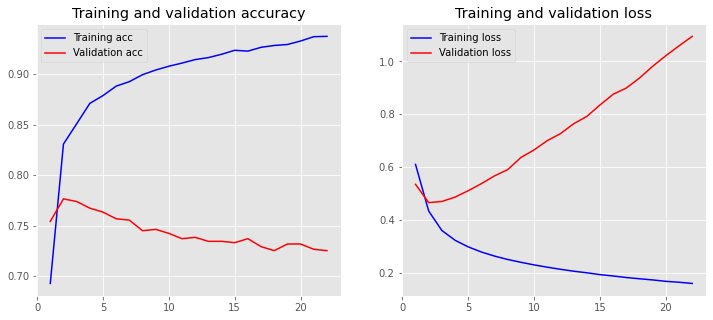

In [172]:
plot_history(first_history_tf_idf)

## Segundo modelo, con conv1D y maxPooling (anda muy mal)

In [173]:
# embedding_dim = 100
# model2_tf_idf = Sequential()
# model2_tf_idf.add(layers.Embedding(2400, embedding_dim, input_length=2392))
# model2_tf_idf.add(layers.Conv1D(128, 5, activation='relu'))
# model2_tf_idf.add(layers.GlobalMaxPooling1D())
# model2_tf_idf.add(layers.Dense(10, activation='relu'))
# model2_tf_idf.add(layers.Dense(1, activation='sigmoid'))
# model2_tf_idf.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['acc'])
# model2_tf_idf.summary()

In [174]:
# second_history_tf_idf = model2_tf_idf.fit(x_train_tf_idf.values, train_tf_idf["target"].to_numpy(),
#                     epochs=3,
#                     verbose=True,
#                     validation_data=(x_val_tf_idf.values, val_tf_idf["target"].to_numpy()),
#                     batch_size=10)

In [175]:
# loss, accuracy = model2_tf_idf.evaluate(x_test_tf_idf.values, test_tf_idf["target"].to_numpy(), verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))

## Modelo con más features, usando set de datos comun

In [176]:
test_limpio = pd.read_csv("test_limpio_con_BOW_de_5000_y_Stemming.csv",encoding = "ISO-8859-1")
test_limpio = test_limpio.drop(columns=["sentimiento", "objetividad"])
test_limpio.head(1)

,aa,ab,aba,abandon,abbott,abbswinston,abc,abcnew,abe,abil,...,www\.twitch\.tv\/PKSparkxx-location,www\.youtube\.com\?Malkavius2-location,xiumin\'s\ nonexistent\ solos-location,y\(our\)\ boyfriends\ legs\ -location,y\/e\/l-location,yorkshire\\n-location,youtube\.com\/channel\/UCHWTLC9B4ZjUGh7yDlb55Iw-location,zboyer\@washingtontimes\.com-location,longitud_tweet,letras_seguidas
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,40,2


In [177]:
train_limpio = pd.read_csv("train_limpio_con_BOW_de_5000_y_Stemming.csv",encoding = "ISO-8859-1")
train_limpio = train_limpio.drop(columns=["sentimiento", "objetividad", "id"])
train_limpio.head(1)

,aa,ab,aba,abandon,abbott,abbswinston,abc,abcnew,abe,abil,...,www\.twitch\.tv\/PKSparkxx-location,www\.youtube\.com\?Malkavius2-location,xiumin\'s\ nonexistent\ solos-location,y\(our\)\ boyfriends\ legs\ -location,y\/e\/l-location,yorkshire\\n-location,youtube\.com\/channel\/UCHWTLC9B4ZjUGh7yDlb55Iw-location,zboyer\@washingtontimes\.com-location,longitud_tweet,letras_seguidas
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,70,2


In [178]:
train_limpio_more_features_true = train_limpio.loc[train_limpio["target"] == 1].sample(frac=1).reset_index(drop=True)
train_limpio_more_features_false = train_limpio.loc[train_limpio["target"] == 0].sample(frac=1).reset_index(drop=True)

In [179]:
train_more_feature = pd.concat([train_limpio_more_features_true.iloc[:2616], train_limpio_more_features_false.iloc[:3473]])
val_more_feature = pd.concat([train_limpio_more_features_true.iloc[2616:3000], train_limpio_more_features_false.iloc[3473:3850]])
test_more_feature = pd.concat([train_limpio_more_features_true.iloc[3000:], train_limpio_more_features_false.iloc[3850:]])

train_more_feature_target = train_more_feature.pop("target")
val_more_feature_target = val_more_feature.pop("target")
test_more_feature_target = test_more_feature.pop("target")

In [180]:
min_max_scaler = preprocessing.MinMaxScaler()
x_train_features_values = min_max_scaler.fit_transform(train_more_feature.values)
x_val_features_values = min_max_scaler.fit_transform(val_more_feature.values)
x_test_features_values = min_max_scaler.fit_transform(test_more_feature.values)

train_more_feature = pd.DataFrame(x_train_features_values)
val_more_feature = pd.DataFrame(x_val_features_values)
test_more_feature = pd.DataFrame(x_test_features_values)

In [181]:
actual_test_ids = test_limpio.pop("id")
test_limpio_values = min_max_scaler.fit_transform(test_limpio.values)
actual_test_limpio = pd.DataFrame(test_limpio_values)

In [182]:
input_dim = train_more_feature.shape[1]  # Number of features

modelFeatures = Sequential()
modelFeatures.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
modelFeatures.add(layers.Dense(1, activation='sigmoid'))

modelFeatures.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])
modelFeatures.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 10)                78460     
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 11        
Total params: 78,471
Trainable params: 78,471
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
609/609 [==============================] - 1s 1ms/step - loss: 0.5268 - acc: 0.7681 - val_loss: 0.4473 - val_acc: 0.8003
Epoch 2/10
609/609 [==============================] - 1s 2ms/step - loss: 0.3544 - acc: 0.8566 - val_loss: 0.4493 - val_acc: 0.8042
Epoch 3/10
609/609 [==============================] - 1s 2ms/step - loss: 0.2784 - acc: 0.8934 - val_loss: 0.4737 - val_acc: 0.7911
Epoch 4/10
609/609 [==============================] - 1s 2ms/step - loss: 0.2252 - acc: 0.9138 - val_loss: 0.5222 - val_acc: 0.7806
Epoch 5/10
609/609 [==============================] - 1s 1ms/step - loss: 0.1865 - acc: 0.9281 - val_loss: 0.5721 - val_acc: 0.7700
Epoch 6/10
609/609 [==============================] - 1s 1ms/step - loss: 0.1550 - acc: 0.9440 - val_loss: 0.6241 - val_acc: 0.7700
Epoch 7/10
609/609 [==============================] - 1s 2ms/step - loss: 0.1300 - acc: 0.9542 - val_loss: 0.6948 - val_acc: 0.7661
Epoch 8/10
609/609 [==============================] - 1s 1ms/step - loss: 0.

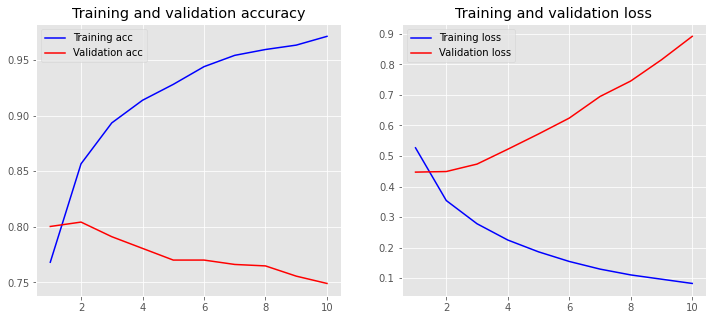

In [183]:
features_history = modelFeatures.fit(train_more_feature.to_numpy(dtype="float32"), train_more_feature_target.to_numpy(dtype="float32"),
                    epochs=10,
                    verbose=True,
                    validation_data=(val_more_feature.to_numpy(dtype="float32"), val_more_feature_target.to_numpy(dtype="float32")),
                    batch_size=10)
loss, accuracy = modelFeatures.evaluate(train_more_feature.to_numpy(dtype="float32"), train_more_feature_target.to_numpy(dtype="float32"), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = modelFeatures.evaluate(test_more_feature.to_numpy(dtype="float32"), test_more_feature_target.to_numpy(dtype="float32"), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(features_history)

In [184]:
moreFeaturesPredictions = list(map(lambda x: x[0], modelFeatures.predict_classes(actual_test_limpio.to_numpy(dtype="float32"))))

In [185]:
moreFeaturesPredictionsDF = pd.DataFrame(data={'id': actual_test_ids, 'target': moreFeaturesPredictions})
moreFeaturesPredictionsDF.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [186]:
moreFeaturesPredictionsDF.to_csv('NN_predictions_more_features.csv', index=False)